In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

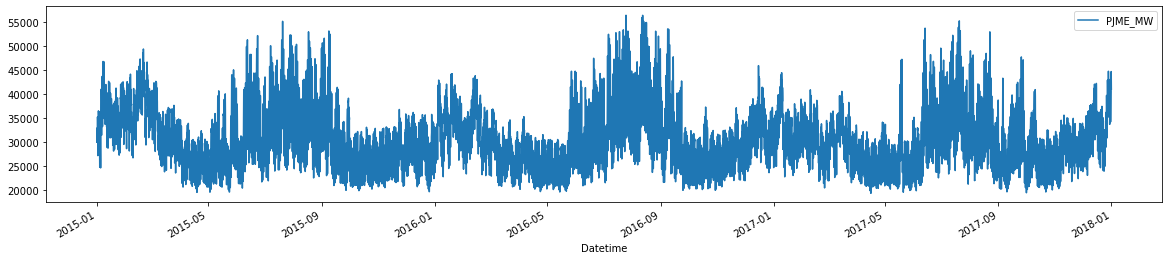

In [2]:
df = pd.read_csv('PJME_hourly.csv', parse_dates=True, index_col="Datetime")
df = df.sort_index(axis=0)
df["2015":"2017"].plot(figsize=(20,4))
df = df.loc["2005":"2015"]
df = df.resample("1h").last().ffill()

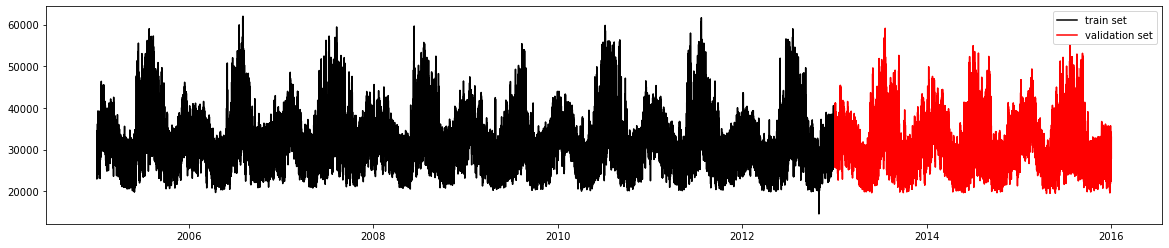

In [3]:
# When there 
y_train = df["2005":"2012"]
y_val = df["2013":"2015"]

plt.figure(figsize=(20,4))
plt.plot(y_train, "k", label="train set")
plt.plot(y_val, "r", label="validation set")
plt.legend()

# Prepare the dataset

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(100)
    
    return dataset

In [9]:
data = df.PJME_MW.values
data

array([27384., 25978., 24641., ..., 30404., 29210., 27944.])

In [10]:
window_size=24
batch_size=32
shuffle_buffer=10000

In [11]:
train_set = windowed_dataset(series=data,
                             window_size=window_size,
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                750       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,071
Trainable params: 1,071
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-17-a283dc56bf1d>", line 11, in <module>
      history = model.fit(train_set, epochs=100)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/gaureshkapoor/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x105ea7aa0
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_2667]

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Set the learning rate
learning_rate = 4e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=30)

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
forecast_series = data[-1001:-1]

In [ ]:
# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

In [ ]:
plt.figure(figsize=(20,7), dpi=200)
plt.plot(np.arange(0, results.shape[0], 1), results, 'r--', label="predictions")
plt.plot(np.arange(0, results.shape[0], 1), data[-results.shape[0]:], 'b', label="real")
plt.legend()

In [ ]:
y_true = data[-results.shape[0]:]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = mean_squared_error(y_true, results, squared=False)
mae = mean_absolute_error(y_true, results)
rmse, mae